# Training Dataset Generation

This notebook demonstrates how to read raw market data from [QUANTAXIS](https://github.com/QUANTAXIS/QUANTAXIS) package and generate training datasets accordingly based on deep learning model needs, assuming market data is already downloaded and stored locally through QUANTAXIS CLI or otherwise possessed in some way.

## Data Format

Before anything, agreeing on the trading data format is necessary. I have spent way more time than I'm willing to on trying to figure out the raw data format and pre-processing routines when researching others' repositories. 

If not familiar with QUANTAXIS, the raw market data are essentially `pd.DataFrame` instances whose format is more or less similar to the following:

|                                                     |    open |    high |     low |   close |           volume |   trade |   amount |   time_stamp | date       | type   |
|:----------------------------------------------------|--------:|--------:|--------:|--------:|-----------------:|--------:|---------:|-------------:|:-----------|:-------|
| (Timestamp('2020-01-01 00:00:00'), 'HUOBI.btcusdt') | 7194.7  | 7221.91 | 7186.19 | 7213.05 |      1.56942e+06 |    1772 | 217.941  |   1577808000 | 2020-01-01 | 5min   |
| (Timestamp('2020-01-01 00:05:00'), 'HUOBI.btcusdt') | 7213.48 | 7221.76 | 7206.9  | 7216.42 | 545030           |     665 |  75.5441 |   1577808300 | 2020-01-01 | 5min   |
| (Timestamp('2020-01-01 00:10:00'), 'HUOBI.btcusdt') | 7216.85 | 7217.05 | 7204.95 | 7206.03 | 542448           |     586 |  75.2413 |   1577808600 | 2020-01-01 | 5min   |
| (Timestamp('2020-01-01 00:15:00'), 'HUOBI.btcusdt') | 7206.02 | 7224.12 | 7202.49 | 7223.27 | 927444           |     979 | 128.582  |   1577808900 | 2020-01-01 | 5min   |
| (Timestamp('2020-01-01 00:20:00'), 'HUOBI.btcusdt') | 7223.26 | 7223.26 | 7216.49 | 7217.81 | 159531           |     763 |  22.0955 |   1577809200 | 2020-01-01 | 5min   |

The above table is an example of the cryptocurrency trading data of BTC/USDT pair with 5-minute intervals, starting from Jan. 1, 2020. Here is a sample daily data from China stock market:

|                                              |   open |   high |   low |   close |   volume |      amount |
|:---------------------------------------------|-------:|-------:|------:|--------:|---------:|------------:|
| (Timestamp('2000-01-27 00:00:00'), '000963') |  16.3  |  22.5  | 16.01 |   20.62 |   297107 | 5.24846e+08 |
| (Timestamp('2000-01-28 00:00:00'), '000963') |  19.3  |  19.78 | 18.56 |   18.56 |   117871 | 2.22077e+08 |
| (Timestamp('2000-02-14 00:00:00'), '000963') |  18.21 |  20.3  | 17.71 |   20.07 |    92146 | 1.74449e+08 |
| (Timestamp('2000-02-15 00:00:00'), '000963') |  19.38 |  19.97 | 18.18 |   18.24 |    61216 | 1.18008e+08 |
| (Timestamp('2000-02-16 00:00:00'), '000963') |  18.25 |  18.77 | 17.3  |   17.57 |    46718 | 8.30775e+07 |

The index column of the dataframe is a tuple consisting of the close time and the symbol/stock code, depending on which market the data is from. *Plase notice that the indices are actually named, the first index column is named "datetime" and the second is "code", which can be seen from the later example outputs.*

The two dataframes are slightly different in the columns depending on the market and frequency of the data, but in general the columns should at least contain 

- **trade time**, which is the first element of the index for each row
- **open**
- **close**
- **high**
- **low**
- **volume**
- **amount**

Having established the format of the raw data, one can either retrieve data for processing from QUANTAXIS or forge whatever market data of their own into the same format. 

## 0. Load dependencies

Set up jupyter magic functions and load all necessary packages/modules for processing. For debugging purposes, the visualization functionalities are imported here, read the source code and possibly another notebook documentation for more information about its usages.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# add the project root directory into path so that we can import other modules in the project
_project_root = Path().cwd().absolute().parent
sys.path.append(str(_project_root))

import QUANTAXIS as qa
from datetime import datetime
import pandas as pd
import numpy as np


from utilities.visualizations import mpf_draw_trading_data   # this is a utility function create to display financial data
from matplotlib import pyplot as plt

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改


An example of retrieving data through QUANTAXIS package, notice that the dataframes from it are actually indexed with names "datetime" and "code", so if the later code uses the index names, please refer back to this accordingly. 

In [3]:
btc_symbol = 'HUOBI.btcusdt'
freq = '5min'
start_date = "2021-01-01"
end_date = str(datetime.today())
data = qa.QA_fetch_cryptocurrency_min_adv(btc_symbol, start=start_date, end=end_date, frequence=freq).data
data

,,open,high,low,close,volume,trade,amount,time_stamp,date,type
datetime,code,,,,,,,,,,
2021-01-01 00:00:00,HUOBI.btcusdt,28779.15,28833.00,28684.27,28721.73,1.792196e+07,8497.0,622.966740,1609430400,2021-01-01,5min
2021-01-01 00:05:00,HUOBI.btcusdt,28719.66,28748.02,28680.28,28714.81,2.972855e+06,3571.0,103.512990,1609430700,2021-01-01,5min
2021-01-01 00:10:00,HUOBI.btcusdt,28714.80,28730.09,28619.24,28650.00,3.894965e+06,4467.0,135.813036,1609431000,2021-01-01,5min
2021-01-01 00:15:00,HUOBI.btcusdt,28649.99,28668.10,28544.71,28668.10,4.947598e+06,4977.0,172.928793,1609431300,2021-01-01,5min
2021-01-01 00:20:00,HUOBI.btcusdt,28668.10,28708.62,28640.48,28686.20,3.008566e+06,4702.0,104.907295,1609431600,2021-01-01,5min
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13 17:15:00,HUOBI.btcusdt,35585.28,35648.92,35572.71,35582.65,1.620008e+06,977.0,45.491548,1623575700,2021-06-13,5min
2021-06-13 17:20:00,HUOBI.btcusdt,35582.03,35603.23,35514.68,35567.13,1.814127e+06,1268.0,51.015757,1623576000,2021-06-13,5min
2021-06-13 17:25:00,HUOBI.btcusdt,35572.99,35593.52,35500.85,35552.66,3.308150e+06,1793.0,93.073913,1623576300,2021-06-13,5min


## 1. Construct Training Data

Assuming the deep learning model takes $N$ consecutive candlesticks with attributes: **open, close, high, low, and volume** as input, and returns a 3-class classification output representing the 3 directions of the near future (e.g. prices in the next 6 time periods) given the input: **goes up, goes down, or oscillating sideways** respectively, and the output labels are determined by adopting a method called [**the Triple-Barrier Method**](https://towardsdatascience.com/financial-machine-learning-part-1-labels-7eeed050f32e). 

### 1. 1 - Data Segmentation

The first step is to slide the trading data with a sliding window of $N + T$ where $N$ is the length of the model input and $T$ is the length used to determine the classification labels mentioned in the **TBM** (Triple-Barrier Method).

SHAPES:
segment = (106, 10) | history = (100, 10) | future = (6, 10)


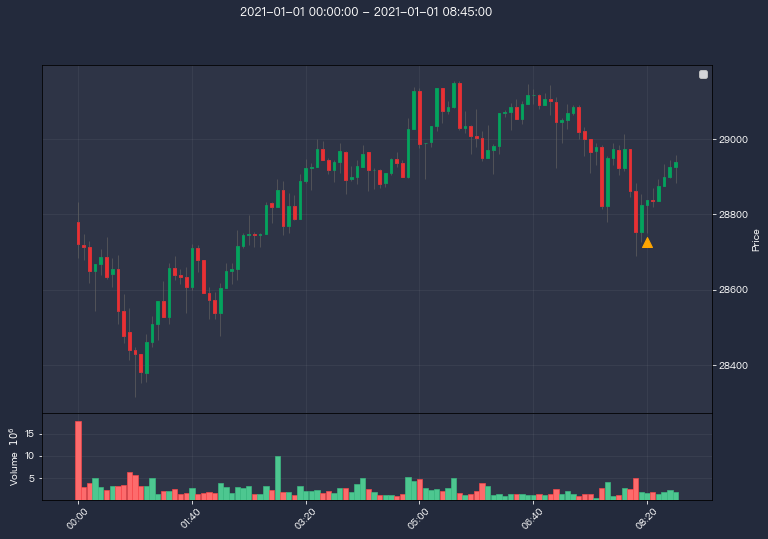

In [4]:
n, t = 100, 6
window_size = n + t

for i in range(0, len(data) - window_size):
    segment = data.iloc[i : i + window_size]
    history = segment[:n]
    future = segment[n:]
    print(f"SHAPES:\nsegment = {segment.shape} | history = {history.shape} | future = {future.shape}")
    s = history.iloc[-1].name[0]
    mpf_draw_trading_data(segment, seps=[s]);
    break
    

The above code snippet shows how to slide the data with a given sliding window size and segment it into `history` and `future`, where `history` is the data intended to be fed into the neural network and `future` is used to determine the label. In the figure above, the yellow chevron denotes the start of the `future` segment. (The equivalent generator function `segment_trading_data()` is implemented in the `dataset_management/tools.py` module.)

In [5]:
from tools import segment_trading_data
segments = segment_trading_data(data=data, n=100, t=12)

for i, (history, future) in enumerate(segments):
    """DO SOMETHING WITH history AND future DATA HERE"""
    break

### 1. 2 - Label the segments

The second step is to assign each segment a label, based on TBM. According to the article, the volatility of the previous prices is taken into account when determining the upper and lower bounds.

Let's take a random segment and try to assign the correct label to it.

It is easy to know that the definition of volatility in finance is simply equivalent to standard deviation in statistics with a minor difference:

$\text{volatility} = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N}(P_i - \overline{P})^2}$ whereas $\text{standard deviation} = \sqrt{\dfrac{1}{N - 1} \sum_{i=1}^{N}(P_i - \overline{P})^2}$

Therefore setting the attribute `ddof=0`.

After getting the volatility, the upper and lower bounds of the triple-barrier is defined accordingly, which is 

$\text{upper} = k_{up}v + p_0$ and $\text{lower} = -k_{lo}v + p_0$,

where $k_{up}$ and $k_{lo}$ are the upper and lower bounds magnitudes, $v$ is the volatility, and $p_0$ is the closing price of the last candlestick. It means that the upper and lower bounds of the TBM are some magnitudes of the volatility away from the closing price.

In [6]:
segments = segment_trading_data(data=data, n=100, t=12, norm=True)
r = 4                       # this is a random number, meaning that I'm taking the r-th segment as a sample
for _ in range(r):
    history, future = next(segments)

volatility = history['close'].std(ddof=0)

k_up, k_lo = 1., 1.
last_bar = history.iloc[-1]
last_closing_price = last_bar['close']
upper_bound = k_up * volatility + last_closing_price
lower_bound = -k_lo * volatility + last_closing_price

Now that the upper, lower bounds are calculated, let's visualize it to check if it all makes sense.

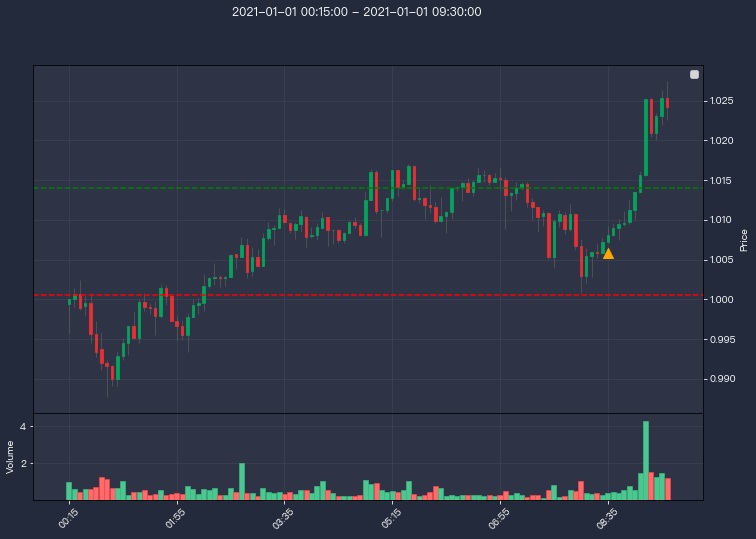

In [7]:
separator = last_bar.name[0]
fig, (main_ax, vol_ax) = mpf_draw_trading_data(pd.concat([history, future]), seps=[separator])
main_ax.axhline(upper_bound, color='g', linewidth=1.5, ls='--')
main_ax.axhline(lower_bound, color='r', linewidth=1.5, ls='--');

From the above plot, it's easy to see that the future price goes up and penetrates the upper bound, hence the label $y=1$. 

*Please note that the data here is randomly taken, and the example data is not necessarily the same for everyone who run this notebook, so this illustration might not be accurate for you*

Now let's write the code to determine the label based on the code we already have.

In [8]:
# determine the label
above_upper, = np.nonzero((future['close'] > upper_bound).values)
below_lower, = np.nonzero((future['close'] < lower_bound).values)
first_above = above_upper[0] if len(above_upper) else len(future) + 1
first_below = below_lower[0] if len(below_lower) else len(future) + 1

if first_above < first_below:
    label = 1
elif first_below < first_above:
    label = -1
else:
    label = 0

label

1

The above procedure is implemented in `dataset_management/tools.py` as function `compute_label()`.

### 1. 3 - Data Normalization

In deep learning, there is a well-known data pre-processing step called "normalization" and the purpose of it is to rescale data inputs to a universal range to help neural networks converge during training. And the input features we have here are OHLCV, notice that the first 4 features are prices and share more or less the same degree of magnitude; whereas the volume is there by its own. Therefore the normalization of the input data is as follows:

$\text{open}' = \dfrac{\text{open}}{a}$

$\text{close}' = \dfrac{\text{close}}{a}$

$\text{high}' = \dfrac{\text{high}}{a}$

$\text{low}' = \dfrac{\text{low}}{a}$

$\text{volume}' = \dfrac{\text{volume}}{b}$

where $a$ is the anchor price, here we take the first closing price as its value, and $b$ is the anchor volume, similarly we take the first volume as its value.

The implementation can be integrated into the previous code snippet when we segment the data:

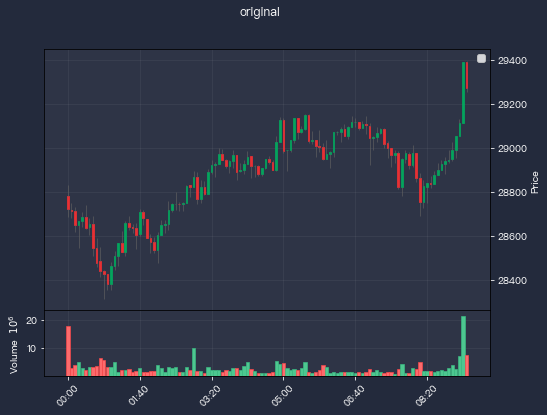

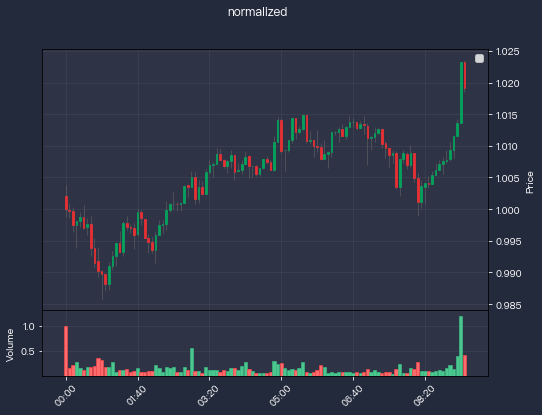

In [9]:
def segment_trading_data(data: pd.DataFrame, n: int=144, t: int=6, norm=False):
    """ Slide the given trading data and generate segments
        data:   the trading data formatted as QUANTAXIS DataStruct
        n:      history window size, default to 144 (12 hours of 5min data)
        t:      future window size, default to 6 (half hour of 5min data)
        norm:   specify whether to normalize the input data
        :return : generator of (history, future) pair
    """
    window_size = n + t
    for i in range(0, len(data) - window_size + 1):
        segment = data.iloc[i : i + window_size].copy()
        if norm:
            anchor_price = segment['close'].iloc[0]
            anchor_volume = segment['volume'].iloc[0]
            segment[['open', 'close', 'high', 'low']] /= anchor_price
            segment['volume'] /= anchor_volume
        history = segment[:n]
        future = segment[n:]
        yield history, future

orig_segments = segment_trading_data(data, 100, 12, False)
norm_segments = segment_trading_data(data, 100, 12, True)

orig_history, orig_future = next(orig_segments)
norm_history, norm_future = next(norm_segments)

mpf_draw_trading_data(pd.concat([orig_history, orig_future]), title='original', figsize=(8, 6));
mpf_draw_trading_data(pd.concat([norm_history, norm_future]), title='normalized', figsize=(8, 6));

### 1. 4 - Put Together

So far, the input data is segmented, normalized, and the labels are determined, the data pre-processing is done. The next step is to put the pieces together to have a comprehensive training data generation pipeline.

Sometimes the neural network model contains the data pre-processing layers to achieve the end-to-end training and inference functionality. So it is a good practice to parameterize the pre-processing options when generating the training datasets. 

Also, when training the model with Tensorflow, PyTorch, or any other deep learning frameworks, usually the data is in `numpy.ndarray` or `tf.EagerTensor` format, so we transform the `pd.DataFrame` into numpy. Recall that the original data might contain columns other than OHLCV, so in this step we are removing unnecessary columns, and keep the columns in the OHLCV order so that we can reconstruct the data later with the same order.

In [42]:
from tools import compute_label

def construct_training_data(data: pd.DataFrame, n: int=144, t: int=6, k_up=1., k_lo=None, norm=False, columns=None):
    if columns is None:
        columns = ['open', 'high', 'low', 'close', 'volume']
    columns = list(columns)
    segments = segment_trading_data(data=data, n=n, t=t, norm=norm)
    for history, future in segments:
        y = compute_label(history, future, k_up=k_up, k_lo=k_lo)
        hist = history[columns].values
        fut = future[columns].values
        '''Converting history and future data from float64 into float32 format is to reduce the size of the data by half'''
        yield hist.astype('float32'), y, fut.astype('float32')


dataset = construct_training_data(data, n=144, t=6, norm=True)
for history, y, future in dataset:
    print(history.shape, type(history), future.shape, type(future))
    break

(144, 5) <class 'numpy.ndarray'> (6, 5) <class 'numpy.ndarray'>


## 2. Writing to File

It is a good habbit to generate the training data and save them into files. 

Following the above instructions, one might notice that the training data samples are generated in a consecutive fashion, meaning that 2 adjacent segments share most of the same data except for 1 candle. This is harmful to model training if familiar with deep learning since it can cause the model to overfit the first few batches of data quickly and to stay in a local-minima position. To resolve this, randomizing the appearance of the segments is one of the most effective way, and saving data into files and randomly re-order them during loading does just that.

Besides, neural network training often takes place on machines with GPU and running Linux operating systems, which might not have direct access to the original trading data. For instance, QUANTAXIS saves trading data into a specified MongoDB instance, usually in a Docker container, and accessing those data from the said GPU machines can be tiresome, but transmitting training dataset files and loading them is not.

Moreover, if using Tensorflow, loading **.tfrecord** files is faster.

Long story short, it's worth implementing the functionality to save the training data into files.

When creating Tensorflow dataset buffer files, it's needed to convert the original training data into the right format, which can be done by serializing numpy arrays into `tfrecord` buffer strings, and it is implemented in the `tfannotation` module as function `create_tfrecord()`, the basic idea is to encode various types of data into their corresponding buffer strings.

In [103]:
from utilities.funcs import create_file_name
from dataset_management.tfannotation import create_tfrecord
import tensorflow as tf
from dataset_management.tools import construct_training_data
from tqdm import tqdm


dataset = construct_training_data(data, n=144, t=6, norm=True)

# specify where you want to put the training dataset files and make sure the directories exist
dataset_dir = _project_root / 'dataset'
train_dir = dataset_dir / 'train'
valid_dir = dataset_dir / 'valid'
train_dir.mkdir(parents=True, exist_ok=True)
valid_dir.mkdir(parents=True, exist_ok=True)
split_ratio = .1

for i, (history, y, future) in tqdm(enumerate(dataset), total=len(data) - (144 + 6) + 1):
    file_name = f"{create_file_name()}.tfrecords"
    
    if i % (1 / split_ratio) < 1:
        file_path = valid_dir / file_name
    else:
        file_path = train_dir / file_name
    
    with tf.io.TFRecordWriter(str(file_path)) as writer:
        serialized = create_tfrecord(history=history, label=y, future=future)
        writer.write(serialized)


100%|██████████| 47007/47007 [03:38<00:00, 215.26it/s]


The above code snippet creates several tfrec files under the `dataset/` directory, now let's check if we can read the data back from those files, and use the same code to load the dataset when training.

To do so, the first step is to find all the files need to be loaded, then create a raw dataset of type `TFRecordDataset`. However, the current dataset cannot be fed into the model nor human-readable yet, because each sample in the dataset is the serialized version of the data, recall the serialization step when creating the files. This brings us to the second step - deserialization. The deserialization function is already implemented in the `tfannotation` module with name `read_tfrecord()`, which decodes a single serialized string, mapping the function with each of the samples in the raw dataset will eventually restore the dataset.

In [127]:
from dataset_management.tfannotation import read_tfrecord

def load_dataset(directory):
    directory = Path(str(directory))
    data_files = [str(p) for p in directory.rglob('*.tfrecords')]
    print(f"[INFO] {len(data_files)} files founded.", flush=True)
    
    raw = tf.data.TFRecordDataset(data_files)
    dataset = raw.map(read_tfrecord)
    return dataset


testsflush== load_dataset(dataset_dir)
for i, sample in enumerate(testset):
    print(f"sample #{i + 1}:")
    history, label, future = sample
    print(f"history var type: {type(history)} dtype: {history.dtype} shape: {history.shape}")
    print(f"label   var type: {type(label)} dtype: {label.dtype} shape: {label.shape}")
    print(f"future  var type: {type(future)} dtype: {future.dtype} shape: {future.shape}")
    print()
    break

[INFO] 47007 files founded.
sample #1:
history var type: <class 'tensorflow.python.framework.ops.EagerTensor'> dtype: <dtype: 'float32'> shape: (144, 5)
label   var type: <class 'tensorflow.python.framework.ops.EagerTensor'> dtype: <dtype: 'int64'> shape: ()
future  var type: <class 'tensorflow.python.framework.ops.EagerTensor'> dtype: <dtype: 'float32'> shape: (6, 5)



## 3. Dataset Distribution Review

Usually the dataset needs to be reviewed and adjusted before training the model since the dataset distribution might be skewed. In this particular case, this could mean that the 3 classes might be unbalanced due to the settings of the **TBM** parameters when creating the data samples. And a visualization of the classes distribution is one of the most straightforward ways to identify such issue.

[INFO] 42306 files founded.
[INFO] 4701 files founded.


42306it [00:08, 4733.25it/s]
336it [00:00, 3355.28it/s]

label -1: 3,804
label 0: 35,057
label 1: 3,445


4701it [00:01, 4477.74it/s]


label -1: 411
label 0: 3,910
label 1: 380


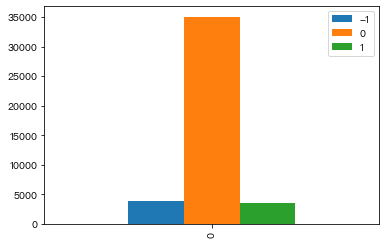

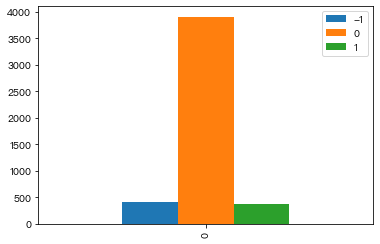

In [130]:
trainset = load_dataset(train_dir)
validset = load_dataset(valid_dir)


def visualize_label_distribution(dataset):
    labels = [-1, 0, 1]
    label_counts = {k: 0 for k in labels}    
    
    for history, label, future in tqdm(dataset):
        label = label.numpy()
        label_counts[label] += 1

    for lb in labels:
        print(f"label {lb}: {label_counts[lb]:,d}", flush=True)
    pd.DataFrame(label_counts, columns=label_counts.keys(), index=[0]).plot.bar();
    

visualize_label_distribution(trainset)
visualize_label_distribution(validset)

The above results depicts that the dataset is extremely unbalanced since the majority of the data samples are labeled 0, this implies that training the deep learning models directly with this dataset might not lead to a robust result and that:

1. either a weighted loss function needs to be implemented during training;
2. or some kind of data augmentation method needs to be adopted;

One easy way of eliminating the distribution skewness is randomly removing some of the data with label 0 to have a balanced dataset, however, doing so will decrease the size of the training set dramatically.

Another possible way is to tune the **TBM** parameters, it could be to increase the window size of the future $T$ to give it more time for the asset to reach either horizontal barriers, or decrease the $k$ parameters so that reaching the take profit or stop loss thresholds become more tangible. 

Have fun generating your own financial datasets!

# JUST SOME EXPERIMENTS

The following is just some experimental code to try to resolve the unbalancing issue.

  0%|          | 28/47001 [00:00<05:31, 141.85it/s]

[INFO] creating tfrec files


100%|██████████| 47001/47001 [03:58<00:00, 196.87it/s]


[INFO] 42300 files founded.
[INFO] 4701 files founded.


42300it [00:16, 2497.96it/s]
427it [00:00, 1925.35it/s]

label -1: 7,839
label 0: 27,373
label 1: 7,088


4701it [00:02, 1958.21it/s]


label -1: 871
label 0: 3,043
label 1: 787


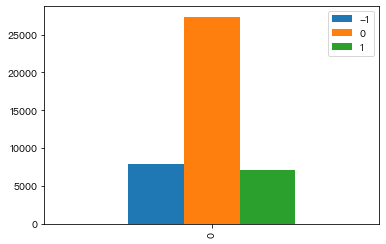

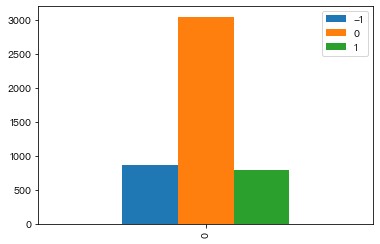

In [133]:
params = dict(
    n=144, 
    t=12,
    k_up=1.,
    norm=True
)
dataset = construct_training_data(data, **params)

dataset_dir = _project_root / 'dataset'
train_dir = dataset_dir / 'train'
valid_dir = dataset_dir / 'valid'
train_dir.mkdir(parents=True, exist_ok=True)
valid_dir.mkdir(parents=True, exist_ok=True)
split_ratio = .1

print(f"[INFO] creating tfrec files", flush=True)
for i, (history, y, future) in tqdm(enumerate(dataset), total=len(data) - (params["n"] + params["t"]) + 1):
    file_name = f"{create_file_name()}.tfrecords"
    
    if i % (1 / split_ratio) < 1:
        file_path = valid_dir / file_name
    else:
        file_path = train_dir / file_name
    
    with tf.io.TFRecordWriter(str(file_path)) as writer:
        serialized = create_tfrecord(history=history, label=y, future=future)
        writer.write(serialized)


trainset = load_dataset(train_dir)
validset = load_dataset(valid_dir)


def visualize_label_distribution(dataset):
    labels = [-1, 0, 1]
    label_counts = {k: 0 for k in labels}    
    
    for history, label, future in tqdm(dataset):
        label = label.numpy()
        label_counts[label] += 1

    for lb in labels:
        print(f"label {lb}: {label_counts[lb]:,d}")
    pd.DataFrame(label_counts, columns=label_counts.keys(), index=[0]).plot.bar();
    

visualize_label_distribution(trainset)
visualize_label_distribution(validset)